In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=RuntimeWarning)
from tqdm import tqdm

In [2]:
def get_log_return(df_market,
                   close_price_column='PX_LAST',
                   date_column='date'):
    """
    get the log returns from the close price of an asset df.
    log returns = log(p_t) - log(p_{t-1}) 


    :param df_market: asset dataframe
    :type df_market: pd.DataFrame
    :param close_price_column: column with the close price
    :type close_price_column: str
    :param date_column: column with the date information
    :type date_column: str
    :return: transformed dataframe
    :rtype: pd.DataFrame
    """
    df_market.loc[:, date_column] = pd.to_datetime(df_market[date_column])
    df_market = df_market.set_index(date_column)
    df_market = df_market[[close_price_column]].dropna()
    df_market = pd.DataFrame(df_market[close_price_column].resample(rule='W-MON').last())
    log_pt =  np.log(df_market[close_price_column])
    log_pt_minus_1 =  np.log(df_market[close_price_column].shift(1))
    df_market.loc[:, "log_pct_change"] = log_pt - log_pt_minus_1
    return df_market.drop(close_price_column, 1).dropna()


def merge_market_trend_dfs(market_df, trends_df,
                           date_column='date'):
    """
    merge market data with the trends dataframe.    
    the values in the trends data are shifted one day forward


    :param df_market: asset dataframe
    :type df_market: pd.DataFrame
    :param trends_df: trends dataframe
    :type trends_df: pd.DataFrame
    :param date_column: column with the date information
    :type date_column: str
    :return: merged dataframe
    :rtype: pd.DataFrame
    """
    trends_df.loc[:,date_column] = pd.to_datetime(trends_df[date_column])
    trends_df = trends_df.set_index(date_column)
    trends_df = trends_df.asfreq('D').shift(1).dropna()
    
    df = pd.merge(market_df, trends_df, right_index=True, left_index=True)
    return df.loc[:, (df != 0).any(axis=0)]


def test_cointegration(ts1,ts2):
    """
    Test cointegration between the time series ts1 and ts2
    using the Engle-Granger Test for Cointegration


    :param ts1: dependent ts
    :type ts1: pd.Series
    :param ts2: independent ts
    :type ts2: pd.Series
    :return: p-value from the Engle-Granger test
    :rtype: float
    """
    lm = sm.OLS(ts1,ts2).fit()
    residuals = (lm.fittedvalues - ts1)
    adf_stats = adfuller(residuals)
    p_value = adf_stats[1]
    return p_value

### Merging market and trends dfs

In [3]:
trends_df = pd.read_csv('data/politics_google.csv')
asset = 'es1'
path = 'data/{}.txt'.format(asset)
market_df = get_log_return(pd.read_csv(path, sep='\t'))
merged_df =  merge_market_trend_dfs(market_df, trends_df)
merged_df.head(2)

,log_pct_change,act,return,election,party,earnings,stock,investment,york,movie,...,governor,office,car,culture,security,religion,labor,marriage,finance,banking
date,,,,,,,,,,,,,,,,,,,,,
2015-07-20,0.013045,2.0,2.0,0.0,7.0,1.0,7.0,1.0,12.0,32.0,...,0.0,14.0,22.0,1.0,5.0,1.0,3.0,2.0,3.0,2.0
2015-07-27,-0.027471,2.0,2.0,0.0,7.0,0.0,6.0,1.0,13.0,32.0,...,0.0,14.0,22.0,1.0,5.0,1.0,3.0,2.0,3.0,2.0


### Adding shift information to word columns

In [4]:
word_columns = list(trends_df.columns)
word_columns =  list(set(word_columns).intersection(merged_df.columns))
word_columns.sort()
word_features = merged_df[word_columns]
shifts =  [1,2,3,4]  

df_shift = merged_df.copy()
for i in shifts:
    word_features_shift = word_features.shift(i).add_suffix("_l{}".format(i))
    df_shift = pd.merge(df_shift, word_features_shift, right_index=True, left_index=True).dropna()
    
df_shift.head(2)

,log_pct_change,act,return,election,party,earnings,stock,investment,york,movie,...,union_l4,virginia_l4,voter_l4,votes_l4,war_l4,washington_l4,water_l4,william_l4,world_l4,york_l4
date,,,,,,,,,,,,,,,,,,,,,
2015-08-17,-0.000239,2.0,2.0,0.0,6.0,0.0,7.0,1.0,13.0,31.0,...,11.0,6.0,0.0,0.0,5.0,9.0,17.0,3.0,18.0,12.0
2015-08-24,-0.114974,3.0,2.0,0.0,6.0,0.0,12.0,1.0,13.0,27.0,...,11.0,6.0,0.0,0.0,4.0,9.0,17.0,3.0,17.0,13.0


### Engle-Granger Test for Cointegration

percentage of cointegrated features = 100.0%


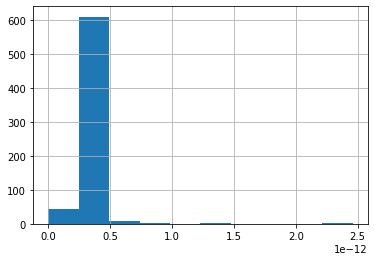

In [5]:
df = df_shift.copy()

feature_columns = list(df.columns)
feature_columns.remove('log_pct_change')


pvalues = {'pval_adfuller_series':[],
           'pval_adfuller_residuals':[]}
Y = df['log_pct_change']

for column in feature_columns:
    X = df[column]
    pvalues['pval_adfuller_series'].append(adfuller(X)[1])
    pvalues['pval_adfuller_residuals'].append(test_cointegration(Y,X))

pvalues = pd.DataFrame(pvalues, index=feature_columns)

alpha = 0.05
cointegrated_series =  pvalues.loc[pvalues["pval_adfuller_residuals"] < alpha].index
cointegrated_series = list(cointegrated_series)

pct_co_features = len(cointegrated_series)/len(feature_columns)
print("percentage of cointegrated features = {:.1%}".format(pct_co_features))

pvalues["pval_adfuller_residuals"].hist().plot();

### Granger Causality

https://en.wikipedia.org/wiki/Granger_causality

In [6]:
granger_prediction_test = {}
Gprediction_series = []

feature_columns = list(merged_df.columns)
feature_columns.remove('log_pct_change')
feature_columns.sort()


for col in feature_columns:
    lag_dict = {}
    df_to_test = merged_df[['log_pct_change', col]]
    try:
        out = sm.tsa.stattools.grangercausalitytests(df_to_test, 4, verbose=False)
        for i in range(1, 5):
            lag_dict['pval_Ftest_l' + str(i)] = out[i][0]['ssr_ftest'][1]
            if lag_dict['pval_Ftest_l' + str(i)] < 0.05:
                df_to_test1 = merged_df[[col, 'log_pct_change']]
                out1 = sm.tsa.stattools.grangercausalitytests(df_to_test1, 4, verbose=False)
                if out1[i][0]['ssr_ftest'][1] > 0.1:
                    Gprediction_series.append(col + '_l' + str(i))
        granger_prediction_test[col] = lag_dict
    except ValueError:
        pass

df_granger = pd.DataFrame(granger_prediction_test).transpose()
    
pct_causal_features = df_granger.shape[0]/len(feature_columns)    
print("percentage of causal features = {:.1%}".format(pct_causal_features))

df_granger.head()

percentage of causal features = 97.7%


,pval_Ftest_l1,pval_Ftest_l2,pval_Ftest_l3,pval_Ftest_l4
DOW JONES,0.116981,4.761954e-07,8.049383e-11,1.336657e-10
act,0.874016,1.020220e-02,2.646247e-02,5.795433e-02
arts,0.460164,2.626820e-01,4.232582e-03,7.229610e-03
banking,0.116970,1.670128e-01,5.093306e-01,6.184662e-01
bonds,0.753882,9.497056e-01,8.715255e-01,8.898695e-01


### Filtered Features

In [7]:
cols_to_subset = list(pd.Series(Gprediction_series + cointegrated_series).unique())
feature_columns = list(df_shift.columns)
feature_columns.remove('log_pct_change')
pct_selected_features = len(cols_to_subset)/ len(feature_columns)
print("percentage of selected features = {:.1%}".format(pct_selected_features))

percentage of selected features = 100.0%


## Regression

In [8]:
def simple_time_series_outofsample_predict(df, model, test_size):
    Y = pd.DataFrame(df[df.columns[0]])
    Y[Y >= 0] = 1
    Y[Y < 0] = -1
    X = df[df.columns[1:len(df.columns)]]
    listOut = []
    Y_train, Y_test, X_train, X_test, = train_test_split(Y, X, test_size=test_size, shuffle=False)
    fit_insample = model.fit(X_train, Y_train.values.flatten())
    df_predict_insample = Y_train.copy()
    df_predict_insample['predict'] = fit_insample.predict(X_train)
    coef_list = []
    for i in range(len(X_test)):
        X_train_in = X_train.append(X_test.iloc[0:i])
        Y_train_in = Y_train.append(Y_test.iloc[0:i])
        X_test_in = X_test.iloc[i:]
        fit = model.fit(X_train_in, Y_train_in.values.flatten())
        coef = pd.DataFrame(fit.coef_)
        coef_list.append(coef)
        outofsample_predict = fit.predict(X_test_in)
        dict = {'date': Y_test.index[i], 'real': Y_test.iloc[i][Y.columns[0]], 'predict': outofsample_predict[0]}
        listOut.append(dict)
    df_rolling_outofsample = pd.DataFrame.from_dict(listOut)
    df_rolling_outofsample.index = df_rolling_outofsample['date']
    del df_rolling_outofsample['date']
    return df_predict_insample, df_rolling_outofsample, coef_list

## Main Script

In [9]:
data = pd.read_csv(path, sep='\t')
data.loc[:, "date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data_close = data[['PX_LAST']]
data_close = data_close.dropna()
data_close = pd.DataFrame(data_close['PX_LAST'].resample(rule='W-MON').last())
data_close['PX_LAST_s1'] = data_close['PX_LAST'].shift(+1)
data_close['log_pct_change'] = np.log(data_close['PX_LAST'] / data_close['PX_LAST_s1'])
del data_close['PX_LAST_s1']
data_close = data_close.dropna()


### Huang, Rojas and Convery 2019 ###
df = df_shift[['log_pct_change'] + cols_to_subset]
X_to_go = df_shift[cols_to_subset]
df_return_out = {}
df_predict_out = {}
df_return_outofsample = {}
df_logpct_outofsample = {}
df_coef_out = []
penality_type = "l1"
trials = 2
tp = '_augmented'
search_space = np.linspace(0.000001, 0.9999999, trials)

for c in tqdm(search_space):
    lasso_model = linear_model.LogisticRegression(penalty=penality_type, C=c, solver='saga')
    lasso_out = simple_time_series_outofsample_predict(df, lasso_model, 0.7)
    df_lasso_in = lasso_out[0]
    df_lasso_out = lasso_out[1]
    df_lasso_tot = pd.concat([df_lasso_in, df_lasso_out])
    df_lasso_tot = pd.merge(data_close, df_lasso_tot['predict'], right_index=True, left_index=True)
    df_lasso_tot[penality_type + '_return'] = df_lasso_tot['log_pct_change'] * df_lasso_tot['predict']
    df_lasso_tot[penality_type + '_return'] = ((1 + df_lasso_tot[penality_type + '_return']).cumprod())
    df_return_out[penality_type + '_' + str(c)] = df_lasso_tot[penality_type + '_return']
    df_lasso_out = pd.merge(data_close, df_lasso_out['predict'], right_index=True, left_index=True)
    df_lasso_out[penality_type + '_return'] = df_lasso_out['log_pct_change'] * df_lasso_out['predict']
    df_logpct_outofsample[penality_type + '_' + str(c)] = df_lasso_out[penality_type + '_return']
    df_lasso_out[penality_type + '_return'] = ((1 + df_lasso_out[penality_type + '_return']).cumprod())
    df_return_outofsample[penality_type + '_' + str(c)] = df_lasso_out[penality_type + '_return']
    df_predict_out[penality_type + '_' + str(c)] = df_lasso_tot['predict']
    df_coef = pd.concat(lasso_out[2])
    df_coef.columns = X_to_go.columns
    df_coef['penality_type'] = penality_type
    df_coef['lambda'] = c
    df_coef['date'] = df_lasso_out.index
    df_coef = df_coef.melt(id_vars=['penality_type','lambda','date'])
    df_coef_out.append(df_coef)
    
df_coef_out = pd.concat(df_coef_out)
df_return_out = pd.DataFrame.from_dict(df_return_out)
df_predict_out = pd.DataFrame.from_dict(df_predict_out)
df_return_outofsample = pd.DataFrame.from_dict(df_return_outofsample)
df_logpct_outofsample = pd.DataFrame.from_dict(df_logpct_outofsample)

100%|██████████| 2/2 [00:52<00:00, 26.39s/it]


In [10]:
df_coef_out.to_csv('results/df_coef_' + asset.split()[0] + '_l1_l2' + tp + '.csv')
df_return_out.to_csv('results/df_return_' + asset.split()[0] + '_l1_l2' + tp + '.csv')
df_predict_out.to_csv('results/df_predict_' + asset.split()[0] + '_l1_l2' + tp + '.csv')
df_return_outofsample.to_csv('results/df_return_outofsample_' + asset.split()[0] + '_l1_l2' + tp + '.csv')
df_logpct_outofsample.to_csv('results/df_logpct_outofsample' + asset.split()[0] + '_l1_l2' + tp + '.csv')

In [11]:
df_coef_out.describe()

,lambda,value
count,238070.000000,238070.000000
mean,0.500000,0.000281
std,0.500001,0.007019
min,0.000001,-0.081727
25%,0.000001,0.000000
50%,0.500000,0.000000
75%,1.000000,0.000000
max,1.000000,0.070510
